# Analyse de simularité des commentaires d'un site e-commerce   

## 1-Importation des modules

In [ ]:
#import modules
import pandas as pd
import numpy as np
import nltk
import string
import re
#Install nltk 
!pip install -q wordcloud
#import wordcloud

from wordcloud import WordCloud


import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer

import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2-Description des données

In [ ]:
df= pd.read_csv('7817_1.csv',engine='python',encoding='utf-8',error_bad_lines=False)  #read the datebase
df.head()                                                                             #print the first 5 lines

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,manufacturer,manufacturerNumber,name,prices,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-08-08T00:00:00.000Z,NaN,139.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-09-01T00:00:00.000Z,NaN,126.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2015-07-20T00:00:00.000Z,NaN,69.0,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2017-06-16T00:00:00.000Z,NaN,2.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I bought one of the first Paperwhites and have...,Love / Hate relationship,NaN,NaN,Dougal,NaN,NaN,205 grams
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,Amazon,NaN,Kindle Paperwhite,"[{""amountMax"":139.99,""amountMin"":139.99,""curre...",2016-08-11T00:00:00.000Z,NaN,17.0,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I have to say upfront - I don't like coroporat...,I LOVE IT,NaN,NaN,Miljan David Tanic,NaN,NaN,205 grams


In [ ]:
df.shape                        #print the number of lines : 1597 then the number of column : 27

(1597, 27)

In [ ]:
df.info()                       #Print a concise summary of a DataFrame 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

In [ ]:
df.describe(include='all')     #Generate descriptive statistics

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,manufacturer,manufacturerNumber,name,prices,reviews.date,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
count,1597,1597,1597,1597,774,1597,1597,565,8.980000e+02,1597,965,902,1597,1597,1217,539,900.000000,1177.000000,1597,1597,1580,0.0,0.0,1580,0.0,8.980000e+02,686
unique,66,54,2,19,3,50,42,2,NaN,66,2,6,62,66,382,2,NaN,NaN,499,1048,1270,NaN,NaN,949,NaN,NaN,9
top,AVpfpK8KLJeJML43BCuD,B01BH83OOM,Amazon,"Amazon Devices,Home,Smart Home & Connected Liv...",Black,2017-01-04T03:51:17Z,2017-08-13T08:31:07Z,4.8 in x 6.6 in x 3.2 in,NaN,amazontapalexaenabledportablebluetoothspeaker/...,Amazon,B01BH83OOM,Amazon Tap - Alexa-Enabled Portable Bluetooth ...,"[{""amountMax"":129.99,""amountMin"":129.99,""curre...",2014-07-28T00:00:00Z,True,NaN,NaN,http://www.amazon.com/Amazon-KA416Y-Premium-He...,While I've purchased items from Amazon for yea...,Great product,NaN,NaN,A. Younan,NaN,NaN,1.75 lbs
freq,542,542,1585,542,675,542,542,542,NaN,542,832,542,542,542,42,503,NaN,NaN,104,58,16,NaN,NaN,59,NaN,NaN,542
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.443135e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.584444,4.359388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.443135e+11,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.416444e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.150238,1.021445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.416444e+09,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.416670e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.416670e+11,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.416670e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.416670e+11,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.416670e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.416670e+11,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.487190e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.487190e+11,NaN


In [ ]:
df['reviews.text']     #print the column named "reviews.text"

0       I initially had trouble deciding between the p...
1       Allow me to preface this with a little history...
2       I am enjoying it so far. Great for reading. Ha...
3       I bought one of the first Paperwhites and have...
4       I have to say upfront - I don't like coroporat...
                              ...                        
1592    This is not the same remote that I got for my ...
1593    I have had to change the batteries in this rem...
1594    Remote did not activate, nor did it connect to...
1595    It does the job but is super over priced. I fe...
1596    I ordered this item to replace the one that no...
Name: reviews.text, Length: 1597, dtype: object

## 3-Nettoyage du texte:(la colonne commentaire du Data frame)

In [ ]:
def first_sentence(text):        
  lst=text.split(".")            #split text to a list according to "."
  return lst[0]                  #take the first element(sentence) from the list 

In [ ]:
df['first_sentence'] = df['reviews.text'].apply(first_sentence)   #create new column containing first sentence from each comment
df['first_sentence'][0]                                           #print the first sentence

'I initially had trouble deciding between the paperwhite and the voyage because reviews more or less said the same thing: the paperwhite is great, but if you have spending money, go for the voyage'

In [ ]:
def supprimer_numbers(text):         
  text=re.sub(r'[0-9]+', '', text)   #eliminate numbers from the text
  return text                        

In [ ]:
df['no_number'] = df['first_sentence'].apply(supprimer_numbers)   #create new column containing sentences without numbers 
df['no_number']                                                   #print the new column

0       I initially had trouble deciding between the p...
1          Allow me to preface this with a little history
2                                 I am enjoying it so far
3       I bought one of the first Paperwhites and have...
4       I have to say upfront - I don't like coroporat...
                              ...                        
1592    This is not the same remote that I got for my ...
1593    I have had to change the batteries in this rem...
1594    Remote did not activate, nor did it connect to...
1595             It does the job but is super over priced
1596    I ordered this item to replace the one that no...
Name: no_number, Length: 1597, dtype: object

In [ ]:
df1=df[['no_number','reviews.title']]   #create new dataframe containing both columns 'no_number' and 'title'
df1.head()                              #print the first 5 lignes

,no_number,reviews.title
0,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!"
1,Allow me to preface this with a little history,One Simply Could Not Ask For More
2,I am enjoying it so far,Great for those that just want an e-reader
3,I bought one of the first Paperwhites and have...,Love / Hate relationship
4,I have to say upfront - I don't like coroporat...,I LOVE IT


In [ ]:
df1.drop_duplicates().shape    #from 2700 rows we get 1430 rows after deleting the duplicated rows

(1413, 2)

In [ ]:
#Removing stopwords 
user_defined_stop_words = ['product','Amazon']          #list for the user stopwords
list_of_amazon_product=['']                             #list for the amazon product

i = nltk.corpus.stopwords.words('english')              #list of english stopwords
j = list(string.punctuation) + user_defined_stop_words  #cancatenated list of ponctuation and user stopwords

stopwords = set(i).union(j)                             #create a set of i and j
stopwords=list(stopwords)                               #transform to list

In [ ]:
#Removing stopwords
def remove_stopwords(text):
  no_stopwords=[words for words in text.split() if words not in stopwords]  #create list of words without stopwords
  words_wo_stopwords=' '.join(no_stopwords)                                 #
  return no_stopwords                                                       #

In [ ]:
#Removing ponctuation
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]   #divise le texte en lettres en eliminant les ponctuations
    words_wo_punct=''.join(no_punct)                                        #concatine les mots 
    return words_wo_punct

In [ ]:
#Tokenize 
def tokenize(text):
    split=re.split("\W+",text) #divise le texte en element suivant les espaces en les versant dans une liste
    return split 

### 3.1 Transformer en minuscule

In [ ]:
df1['text_lowercase']=df1['no_number'].apply(lambda x:x.lower())  #create new column for lowercase text
df1[['no_number','text_lowercase']].head()                        #print the 5 first lignes of 'no_number' and 'text_lowercase' columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,no_number,text_lowercase
0,I initially had trouble deciding between the p...,i initially had trouble deciding between the p...
1,Allow me to preface this with a little history,allow me to preface this with a little history
2,I am enjoying it so far,i am enjoying it so far
3,I bought one of the first Paperwhites and have...,i bought one of the first paperwhites and have...
4,I have to say upfront - I don't like coroporat...,i have to say upfront - i don't like coroporat...


### 3.2 Supprimer les ponctuations

In [ ]:
#removing ponctuation
df1['no_ponctuation']=df1['text_lowercase'].apply(remove_punctuation) #create new column without ponctuation
df1[['text_lowercase','no_ponctuation']].head()                       #print the first 5 lignes from 'text_lowercase' and 'no_ponctuation' columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,text_lowercase,no_ponctuation
0,i initially had trouble deciding between the p...,i initially had trouble deciding between the p...
1,allow me to preface this with a little history,allow me to preface this with a little history
2,i am enjoying it so far,i am enjoying it so far
3,i bought one of the first paperwhites and have...,i bought one of the first paperwhites and have...
4,i have to say upfront - i don't like coroporat...,i have to say upfront i dont like coroporate ...


###3.3 Supprimer les stopwords(les mots vides) 

In [ ]:
df1['no_stopwords']=df1['no_ponctuation'].apply(remove_stopwords) #create new column without stopwords
df1[['no_ponctuation','no_stopwords']].head()                     #print the first 5 lignes from 'no_ponctuation' and 'no_stopwords' columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,no_ponctuation,no_stopwords
0,i initially had trouble deciding between the p...,"[initially, trouble, deciding, paperwhite, voy..."
1,allow me to preface this with a little history,"[allow, preface, little, history]"
2,i am enjoying it so far,"[enjoying, far]"
3,i bought one of the first paperwhites and have...,"[bought, one, first, paperwhites, pleased, con..."
4,i have to say upfront i dont like coroporate ...,"[say, upfront, dont, like, coroporate, hermeti..."


### 3.4Tokenization

In [ ]:
def listToString(s): 
    str1 = " "              # initialize an empty string
    return (str1.join(s))   # concatenate list to string 

In [ ]:
df1['no_extraspaces']=df1['no_stopwords'].apply(listToString) #create new column containing sentences (string)
df1[['no_stopwords','no_extraspaces']].head()                 #print the first 5 lignes of 'no_stopwords' and 'no_extraspaces' columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,no_stopwords,no_extraspaces
0,"[initially, trouble, deciding, paperwhite, voy...",initially trouble deciding paperwhite voyage r...
1,"[allow, preface, little, history]",allow preface little history
2,"[enjoying, far]",enjoying far
3,"[bought, one, first, paperwhites, pleased, con...",bought one first paperwhites pleased constant ...
4,"[say, upfront, dont, like, coroporate, hermeti...",say upfront dont like coroporate hermetically ...


In [ ]:
#tokeniZation
df1['tokenized']=df1['no_extraspaces'].apply(tokenize) #create new column of tokenzed sentences
df1[['no_extraspaces','tokenized']].head()             #print the first 5 lignes of 'no_extraspaces' and 'tokenized' columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,no_extraspaces,tokenized
0,initially trouble deciding paperwhite voyage r...,"[initially, trouble, deciding, paperwhite, voy..."
1,allow preface little history,"[allow, preface, little, history]"
2,enjoying far,"[enjoying, far]"
3,bought one first paperwhites pleased constant ...,"[bought, one, first, paperwhites, pleased, con..."
4,say upfront dont like coroporate hermetically ...,"[say, upfront, dont, like, coroporate, hermeti..."


In [ ]:
def lemmatization(lst):
  lst1=[]
  lemmatizer = WordNetLemmatizer()     #create instance for WordNetLemmatizer()
  for word in lst:                     #run all the list 
    word1=lemmatizer.lemmatize(word)   #apply lemmatize()
    lst1.append(word1)                 #add words to lst1
  return lst1                          #lst1 contains 

In [ ]:
df1['lemmatized']=df1['tokenized'].apply(lemmatization) #create new column with lemmatized list
df1[['tokenized','lemmatized']].head()                  #print the first 5 ligne of 'tokenized' and 'lemmatized' column

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tokenized,lemmatized
0,"[initially, trouble, deciding, paperwhite, voy...","[initially, trouble, deciding, paperwhite, voy..."
1,"[allow, preface, little, history]","[allow, preface, little, history]"
2,"[enjoying, far]","[enjoying, far]"
3,"[bought, one, first, paperwhites, pleased, con...","[bought, one, first, paperwhites, pleased, con..."
4,"[say, upfront, dont, like, coroporate, hermeti...","[say, upfront, dont, like, coroporate, hermeti..."


In [ ]:
print(df1['tokenized'][0])                 #print the first ligne of the row 'text_noextraspaces' before lemmatization

['initially', 'trouble', 'deciding', 'paperwhite', 'voyage', 'reviews', 'less', 'said', 'thing', 'paperwhite', 'great', 'spending', 'money', 'go', 'voyage']


In [ ]:
print(lemmatization(df1['tokenized'][0]))  #print the first ligne of the row 'text_noextraspaces' after lemmatization

['initially', 'trouble', 'deciding', 'paperwhite', 'voyage', 'review', 'le', 'said', 'thing', 'paperwhite', 'great', 'spending', 'money', 'go', 'voyage']


In [ ]:
def remove_special_words(lst1):
  lst2=['tv','fire','kindle','last','year','amazon','prime','ipad','app','apple','headphone','netflix','paperwhite',
        'echo','alexa','time','phone','tap','one','tangle','speaker','apps','theyre','case','going','ear','portable',
        'bluetooth','new','back','voice','search','cover','got','wifi','book','reading','read','capacity','light',
        'controller','screen','web','movie','voyage','surfing','roku','device','samsung','gaming','purchased']
  l=[word for word in lst1 if word not in lst2  ] #l doesn't contain any word from lst2
  return l

In [ ]:
df1['no_special_words']=df1['lemmatized'].apply(remove_special_words) #create new column without special words

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df1['sentence']=df1['no_special_words'].apply(listToString)   #create new column containing sentence for each ligne
full_text=" "                                                 
full_text=full_text.join(df1['sentence'])                     #concatenate all sentences
df1['sentence']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0       initially trouble deciding review le said thin...
1                            allow preface little history
2                                            enjoying far
3       bought first paperwhites pleased constant comp...
4       say upfront dont like coroporate hermetically ...
                              ...                        
1592               remote alexaecho doesnt control volume
1593    change battery remote twice per month since march
1594                          remote activate connect box
1595                                     job super priced
1596                     ordered item replace longer work
Name: sentence, Length: 1597, dtype: object

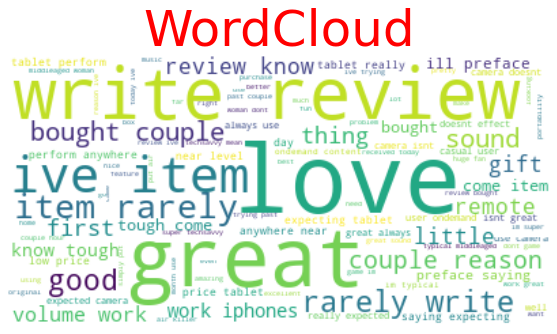

<Figure size 432x288 with 0 Axes>

In [ ]:
wordcloud = WordCloud(max_font_size=70, max_words=100, background_color="white").generate(full_text) #generates a wordcloud from the text
plt.figure( figsize=(10,5) )                                                                         #create a figure with (10,5) dimension
plt.imshow(wordcloud, interpolation="bilinear")                                             
plt.axis("off")                                                                                      #no axis                                                                               
plt.title('WordCloud',size=50,color='red')                                                           #make a title
plt.show()                                                                                           #showing results
plt.savefig("WordCloud.png")                                                                         #save the wordcloud

## 4 TF(Term Frequency)-IDF(Inverse Document Frequency)

In [ ]:
corpus=df1['sentence'].tolist()

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())
print(tfidf_matrix.shape)
tfidf_matrix

['ability', 'able', 'absolutely', 'access', 'acclaimed', 'according', 'account', 'accustomed', 'achat', 'action', 'activate', 'activated', 'activation', 'actual', 'actually', 'adapter', 'adaptes', 'adaptor', 'add', 'added', 'addition', 'additional', 'addon', 'adequate', 'adhering', 'adjusting', 'admit', 'adoptor', 'advanced', 'advantage', 'advertise', 'advertised', 'age', 'agenda', 'ago', 'agreed', 'ai', 'air', 'airplane', 'alarm', 'alexaecho', 'alexaenabled', 'alexas', 'alezxa', 'algorithm', 'alley', 'allin', 'allnew', 'allow', 'allowed', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'alternative', 'although', 'always', 'amazed', 'amazing', 'amazondeducted', 'america', 'amount', 'andhave', 'android', 'announced', 'another', 'answer', 'answered', 'answering', 'anticipated', 'antiglare', 'anybody', 'anyone', 'anysolution', 'anything', 'anytime', 'anyway', 'anywhere', 'apart', 'apartment', 'appareil', 'apparently', 'appearing', 'appears', 'application', 'appreciate', 'april', 

<1597x1657 sparse matrix of type '<class 'numpy.float64'>'
	with 8896 stored elements in Compressed Sparse Row format>

In [ ]:
cols=vectorizer.get_feature_names()

In [ ]:
dense=tfidf_matrix.todense().tolist()
print(dense)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
embedded_df=pd.DataFrame(dense,columns=cols)
embedded_df

,ability,able,absolutely,access,acclaimed,according,account,accustomed,achat,action,activate,activated,activation,actual,actually,adapter,adaptes,adaptor,add,added,addition,additional,addon,adequate,adhering,adjusting,admit,adoptor,advanced,advantage,advertise,advertised,age,agenda,ago,agreed,ai,air,airplane,alarm,...,winner,wired,wireless,wise,wish,wishing,within,without,woke,woman,wonderful,wonderfully,wont,word,work,worked,working,world,worry,worth,would,wouldnt,write,writer,writing,written,wrong,wyou,xbmc,xmas,yellow,yes,yet,youll,young,youre,youve,yr,zerocons,zippy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.621707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix,tfidf_matrix)
print(cosine_sim)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
df2=df1.drop_duplicates(subset=['sentence'])

In [ ]:
indices = pd.Series(df2.index, index=df2['sentence']).drop_duplicates()

In [ ]:
df1['sentence'].iloc[0]

'initially trouble deciding review le said thing great spending money go'

In [ ]:
def get_recommendations(title, cosine_sim, indices):
  # Get the index of the movie that matches the title
  idx = indices[title]
  # Get the pairwsie similarity scores
  sim_scores = list(enumerate(cosine_sim[idx]))
  print(sim_scores)
  # Sort the movies based on the similarity scores
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  # Get the scores for 10 most similar movies
  sim_scores = sim_scores[1:11]
  # Get the movie indices
  movie_indices = [i[0] for i in sim_scores]
  # Return the top 10 most similar movies
  return df1['sentence'].iloc[movie_indices]

In [ ]:
get_recommendations('initially trouble deciding review le said thing great spending money go', cosine_sim, indices)

[(0, 1.0000000000000002), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 1.0000000000000002), (9, 0.0), (10, 0.03796331649848985), (11, 0.0), (12, 0.0), (13, 0.0), (14, 0.049114451932882), (15, 0.0), (16, 0.05044109229177531), (17, 0.0), (18, 0.09817460197274157), (19, 0.0), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0), (25, 0.040364252419647154), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.040364252419647154), (30, 0.040364252419647154), (31, 0.040364252419647154), (32, 0.0), (33, 0.0), (34, 0.0), (35, 0.0), (36, 0.02622826341758954), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.0), (41, 0.15524028385491973), (42, 0.0), (43, 0.08115627821983876), (44, 0.0), (45, 0.0), (46, 0.0), (47, 0.0), (48, 0.0), (49, 0.0), (50, 0.040364252419647154), (51, 0.0), (52, 0.0), (53, 0.0), (54, 0.040364252419647154), (55, 0.0), (56, 0.0), (57, 0.0), (58, 0.0), (59, 0.0), (60, 0.0), (61, 0.0), (62, 0.0), (63, 0.0), (64, 0.0), (65, 0.0), (66, 0.0), (67, 0.0), (68, 0.0), (69, 0.0

8       initially trouble deciding review le said thin...
1092                                                   go
928                                  work great lot thing
1241                            prefer spending extra get
818                       actually pretty happy initially
1225                            great additional piece go
694                 really awesome tablet old worth money
1282                   nice item really there thing thing
1076             excellent sound quality good value money
41                                                  great
Name: sentence, dtype: object